In [1]:
import numpy as np
from numpy import median
import seaborn as sns
import pandas as pd
import scipy.stats as ss
from scipy import signal 
import cPickle as pickle
from lab.classes.dbclasses import dbMouse
from scipy.ndimage.interpolation import shift
import itertools as it
import matplotlib.pyplot as plt
from lab.analysis import behavior_analysis as ba
from pandas import read_excel
from scipy.signal import resample as rs
from scipy.ndimage import gaussian_filter1d as gauss
from lab.analysis.imaging_analysis import offsetPCA
from matplotlib.colors import LogNorm

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
with open('All_CA3_Cells_Subtypes_for_Amplitude_Duration_Heatmaps.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
m = []
for mouse in np.unique(data.mouse):
    df1 = data[(data.mouse == mouse)]
    for typ in np.unique(df1.type):
        df2 = df1[(df1.type==typ)]
        for roiid in np.unique(df2.roiID):
            df = df2[(df2.roiID==roiid)]
            
            dur = df['Ripple_Duration'].values
            tr = np.array(map(lambda x: rs(x, 600), df['Peri_Ripple_Trace'].values))
                        
            pcts = [0, 20, 40, 60, 80, 100]
            for i, thr in enumerate(pcts[:-1]):
                low = np.percentile(dur, pcts[i])
                high = np.percentile(dur, pcts[i+1])
                idx = np.where((dur>low) & (dur<high))[0]
        
                pre = np.mean(np.mean(tr[idx, 100:300],axis=1))
                post = np.mean(np.mean(tr[idx, 300:500],axis=1))
        
                m.append({'sbt': typ, 'time': 'pre', 'val': pre, 'pct': thr+10})
                m.append({'sbt': typ, 'time': 'post', 'val': post, 'pct': thr+10})
            
m = pd.DataFrame(m)

In [5]:
m['idx'] = 0
m.loc[m.sbt == 'AAC', 'idx'] = 1
m.loc[m.sbt == 'SOM', 'idx'] = 2
m.loc[m.sbt == 'CCK', 'idx'] = 3
m.loc[m.sbt == 'CB', 'idx'] = 4

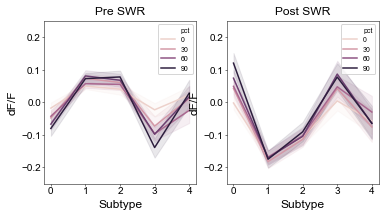

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.lineplot(x='idx', y='val', hue='pct', data=m[m.time == 'pre'], ci = 68, err_kws={'alpha':0.1}, ax = ax[0])
ax[0].set_xlabel('Subtype', fontsize=12)
ax[0].set_ylabel('dF/F', fontsize=12)
ax[0].set_title('Pre SWR', fontsize=12)
ax[0].set_ylim(-0.25, 0.25)


sns.lineplot(x='idx', y='val', hue='pct', data=m[m.time == 'post'], ci = 68, style_order = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB'], err_kws={'alpha':0.1}, ax = ax[1])
ax[1].set_xlabel('Subtype', fontsize=12)
ax[1].set_ylabel('dF/F', fontsize=12)
ax[1].set_title('Post SWR', fontsize=12)
ax[1].set_ylim(-0.25, 0.25)

plt.savefig('Pre_post_byPCT.pdf')